# Fraud Detection
## This notebook serves as practice to deal with an unbalanced dataset. There are more 'Non-Fraud' instances than 'Fraud'. 
### There are many ways to tackle this problem, which will be outlined as follows:

[Importing](#Importing)

[Undersampling](#Undersampling)
- [Utilizing Dimensionality Reduction](#Utilizing-Dimensionality-Reduction)
- [Utilizing Near Miss](#Utilizing-Near-Miss)

[Oversampling](#Oversampling)

# Importing
I will begin by importing all the packages that will prove useful in this notebook. Then, I will import the dataset by reading it in as a CSV. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections
from sklearn.model_selection import KFold
from scipy.stats import norm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import time
import matplotlib.patches as mpatches
from numpy import percentile
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

In [2]:
path = 'D:/Machine_Learning/Fraud Detection/'
file = 'creditcard.csv'

df = pd.read_csv(path+file)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Splitting the Data
Once we have the dataframe, it will be useful to split up the features from the labels so that we can begin using Machine Learning Algorithms. This will be done multiple times, however I wanted to keep the origianl dataset together for validation much later on. Thus these newly created variables will not see much use until that point. 

In [3]:
X = df.drop(labels = 'Class', axis = 1)
y = df['Class']

### Standardizing Columns
This dataset was downloaded from Kaggle. In its description, it noted that the columns 'V1' - 'V28' were standardized as a result from PCA. As noted above, you can see that the columns 'Time' and 'Amount' are not standardized. To keep dataframe consistent, I will standardize the aforementioned columns below. 

In [4]:
time_bar, time_std = np.mean( X['Time'] ), np.std( X['Time'] )
amt_bar, amt_std = np.mean( X['Amount'] ), np.std( X['Amount'] )
X['Time Scaled'] = ( X['Time'] - time_bar)/ time_std
X['Amount Scaled'] = ( X['Amount'] - amt_bar)/ amt_std
X = X.drop(columns = ['Time','Amount'])

### Class Distributions
Below I will create two functions. The first - percentage_finder - will determine how imbalanced the dataset is. 
The second - distribution_chart - plots the distribution of the labels.

In [5]:
def percentage_finder(y):
    '''
    This function only takes one parameter.
    ---------------------------------------
    y: pandas Series
        It should be the targets of your data set.
    -----------------------------------------
    Prints percentages of each label in your dataset.
    '''
    print('Non-Fraud occurences: %i' %y.value_counts()[0], end = ', ')
    print('Fraud occurences: %i' %y.value_counts()[1])
    print('Percentage that are Non-Fraud: %.2f' 
          %(y.value_counts()[0]*100/len(y)) )
    print('Percentage that are Fraud: %.2f' 
          %(y.value_counts()[1]*100/len(y)) )
    
def distribution_chart(y):
    '''
    This function only takes one parameter.
    ---------------------------------------
    y: pandas Series
        It should be the targets of your data set.
    -----------------------------------------
    Plots the distribution of the labels in your data set.
    '''
    plt.bar([0,1], [y.value_counts()[i] for i in [0,1]])
    plt.title('Class Distribution')
    plt.xlabel('Label')
    plt.xticks([0,1], ['Non Fraud', 'Fraud'])
    plt.ylabel('Count')

In [6]:
percentage_finder(y)

Non-Fraud occurences: 284315, Fraud occurences: 492
Percentage that are Non-Fraud: 99.83
Percentage that are Fraud: 0.17


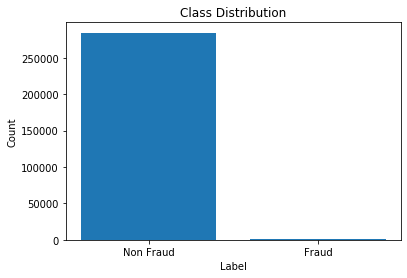

In [7]:
distribution_chart(y)

As you can see above, there is a huge imbalance here! Only 0.17% of the data comes from the 'Fraud' category. Thus it is clear that a model which tried to optimize accuracy would not work in this situation (for it would always predict as 'Non-Fraud' and still be correct 99.83% of the time)!

[Back to Top](#Fraud-Detection)

# Undersampling

## Utilizing Dimensionality Reduction

In this approach, we attempt to balance the dataset. As noted from above, there are 492 instances of 'Fraud'. Hence we can decrease the number of 'Non-Fraud' instances closer to this value. You do not need to do a 50-50 split as I will do below, but I felt that it would provide reasonable results. 
An important factor to keep in mind while using this technique is that information will be lost. We are going from 284315 to 984 data points. 

I name the new dataframe 'equal_df' as it has an equal number of both classes. Similarly for the variables X and y.

In [8]:
'''
The best way to balance the dataset with an undersampling technique is to choose the values randomly. I will accomplish
this by permuting the information from the original dataset. With this permutated dataframe, I will then choose just 
the first 492 instances from the oversampled class (the "good" people). And of course I will choose all of the "bad" people
as well.
'''

holder = df.sample(frac = 1, random_state = 1)
undersample_fraud = holder.loc[holder['Class'] == 1]
undersample_nonfraud = holder.loc[holder['Class'] == 0][:492]

'''
Here I concatenate the two series to create the balanced dataframe.
'''
equal_df = pd.concat([undersample_fraud, undersample_nonfraud])
X_equal = equal_df.drop(labels = 'Class', axis = 1)
y_equal = equal_df['Class']

Now that I have created the new dataframe, let us check to see if everything is as it should be. 

In [9]:
percentage_finder(y_equal)

Non-Fraud occurences: 492, Fraud occurences: 492
Percentage that are Non-Fraud: 50.00
Percentage that are Fraud: 50.00


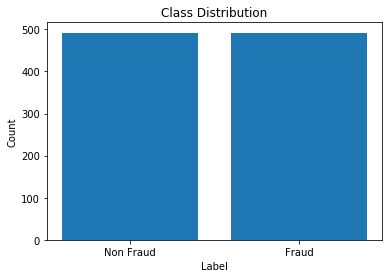

In [10]:
distribution_chart(y_equal)

Okay great! Now we have a completely balanced dataframe. With this, we can begin implementing some Machine Learning techniques. 

## Analyzing Data
Now that we have an equally distributed dataframe, it is best to begin analyzing the information. Unfortunately for us, we are not given what the features are. We only know them by the generic name given. However, we can still find correlations that each feature has with the 'Class' column. 
* The first function - plot_corr -  will plot every pairwise correlation inside of our dataframe. This will be useful for finding which features are the most important.

* The second function - plot_boxplot - will plot boxplots for every column specified and whether it has a negative or positive correlation with the 'Class'.

* The third and last function - plot_distribution - will plot the distribution of given columns to determine their normality.

In [11]:
def plot_corr(dataframe):
    '''
    This function will plot a heatmap of correlations for a given dataframe.
    --------------------------------------------------------------
    dataframe: pandas dataframe
        This should have n_rows and n_columns
    --------------------------------------------
    Plots pairwise correlations of each feature and label
    '''
    fig, ax = plt.subplots(1,1, figsize = (20,10))
    corr = dataframe.corr()
    sns.heatmap(corr, center = 0, cmap = 'RdYlGn')
    ax.set_title('Balanced Correlation Matrix')

    
def plot_boxplot(dataframe, List, Relation):
    '''
    This function will create a boxplot of certain features and their relation,
    whether that be Positive or Negative.
    ---------------------------------------------------------------------------
    dataframe: pandas dataframe
            This is the entire dataframe to be looked at.
            
    List: list of integers
            These are the columns you want to create boxplots for.
            
    Relation: String
            It only takes the values of Positive or Negative.
    ---------------------------------------------------------------------------
    Plots the boxplots of many different columns.
    '''
    
    fig, axes = plt.subplots(1, len(List), figsize = (20,10))
    
    for i in range(len(List)):
        col = 'V' + str(List[i])
        sns.boxplot(x = 'Class', y= col, data = dataframe, 
                    ax = axes[i])
        axes[i].set_title('V%s vs Class: \n %s Correlation' % (List[i], Relation))
                          
                          
def plot_distribution(dataframe, List, Label):
    '''
    This function will plot distribution plots for given columns and given 
    classes.
    ----------------------------------------
    dataframe: pandas dataframe
        This should be the dataframe consisting of all the features.
        
    List: list of integers
        These integers should be the names of the columns to be inspected.
        
    Label: integer
        This should either be 0 or 1. 0 is for Non-Fraud cases and 1 is for Fraud
    -----------------------------------------
    Plots the distributions of each of the specified columns and class.
    '''
    fig, axes = plt.subplots(1, len(List), figsize = (30,10))
    
    for i in range(len(List)):
        name = 'V' + str(List[i])
        col = dataframe[name].loc[dataframe['Class'] == Label].values
        sns.distplot(col, fit = norm, ax = axes[i])
        axes[i].set_title('Distribution of V%s \n %s Transactions'
            %(List[i], np.where(Label == 0, 'Non Fraud', 'Fraud')) )

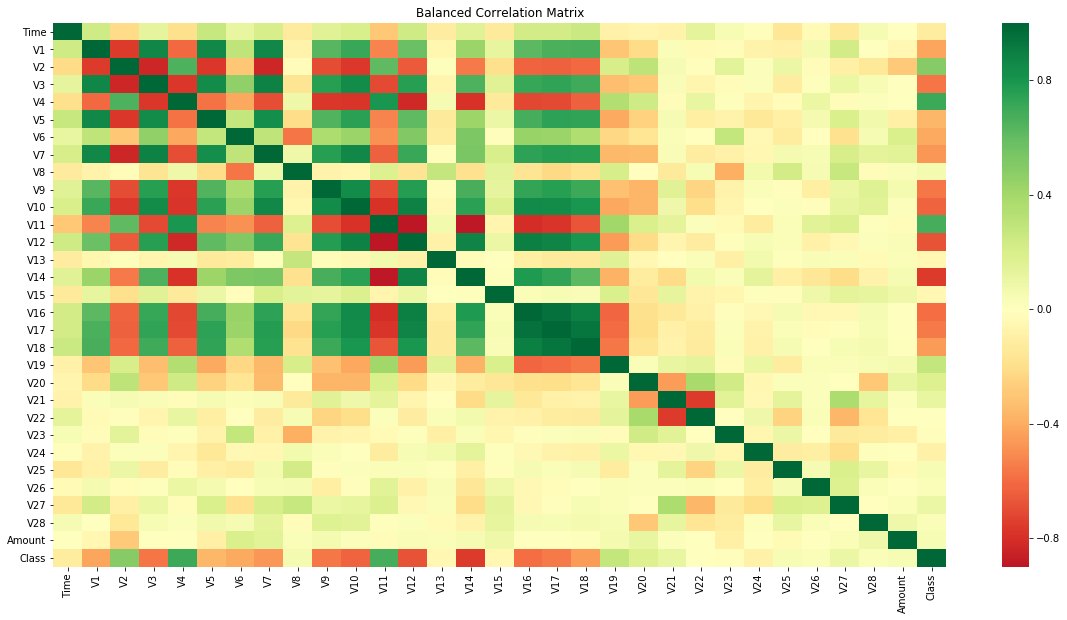

In [12]:
plot_corr(equal_df)

Here we can see that only a few of the features have some sort of correlation with 'Class'. 
* Columns V2, V4, V11, and V19 have the highest positive correlations.

* Columns V10, V12, V14, and V17 have the highest negative correlations.

With this insight, let us now look at the boxplots of each of these to determine if differences can be observed for each 'Class'.

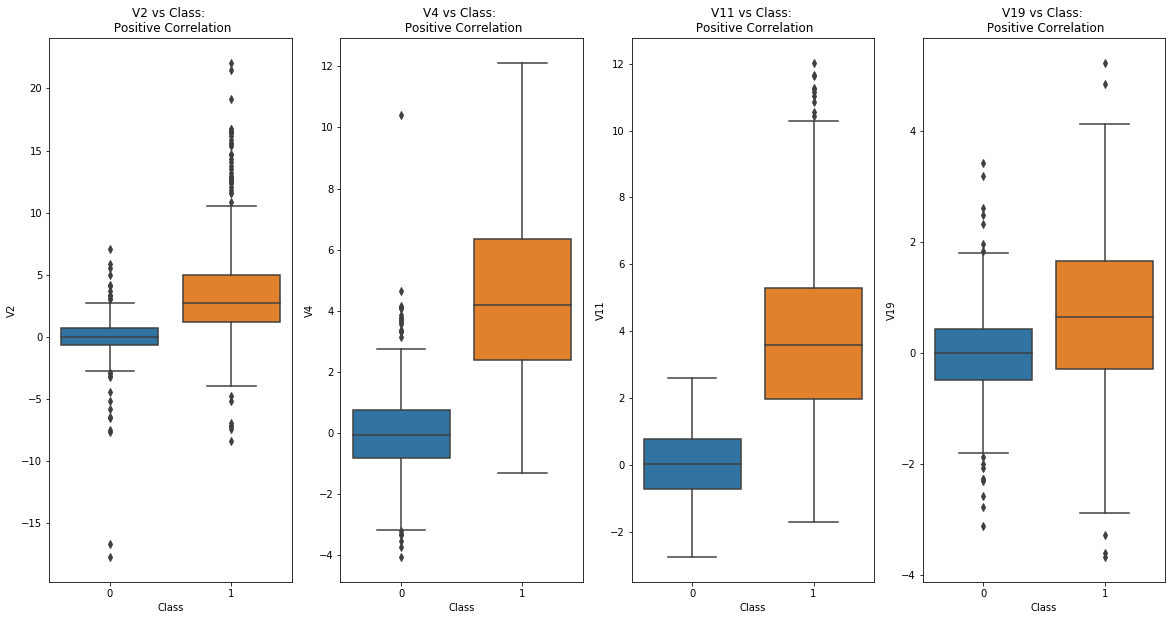

In [13]:
plot_boxplot(equal_df, [2,4,11,19], 'Positive')

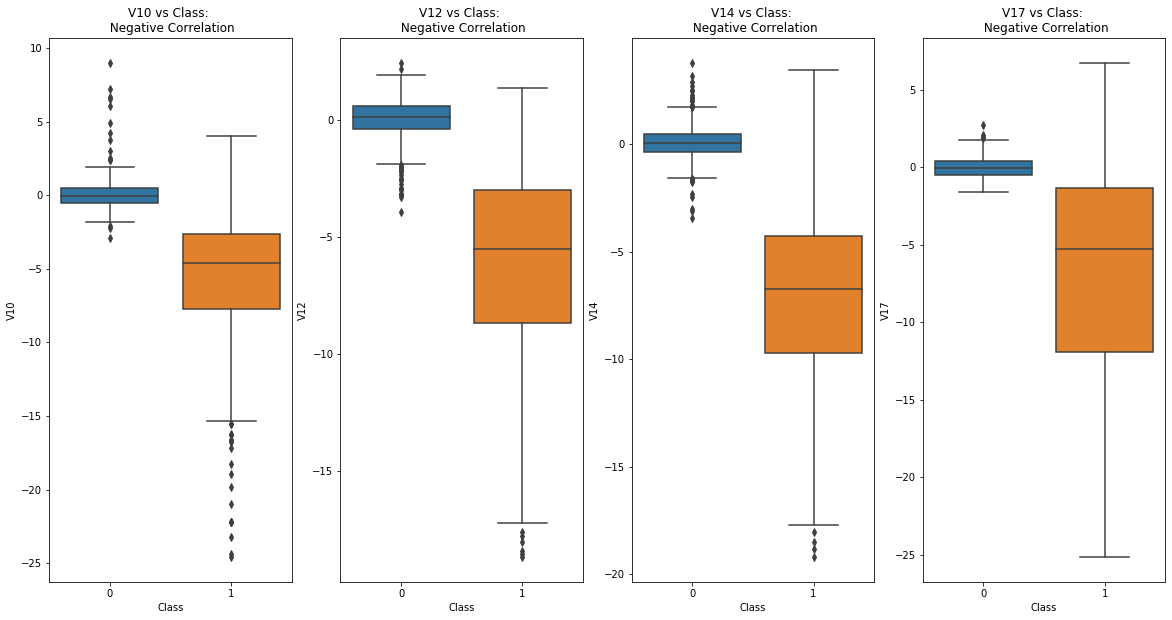

In [14]:
plot_boxplot(equal_df, [10,12,14,17], 'Negative')

There are definitely differences noticeable here. However, we also see that there are many outliers for certain columns. For real world data, it would be nice to comb through those values and see if they are likely to occur or if they are the result of an error. Unfortunately for us, we do not have that luxury since we do not know what the columns represent. Thus I will assume that these outliers are due to errors in hopes to create models with better accuracy. 

One issue that can come from removing outliers is if too much information is lost. Since we only have 492 instances of 'Fraud', doing too much outlier removal will cause us to have a tiny sample to work with. Thus I will only remove outliers from a few columns, namely V2, V10, and V11. From inspection, it looks like these columns had the most outliers. 

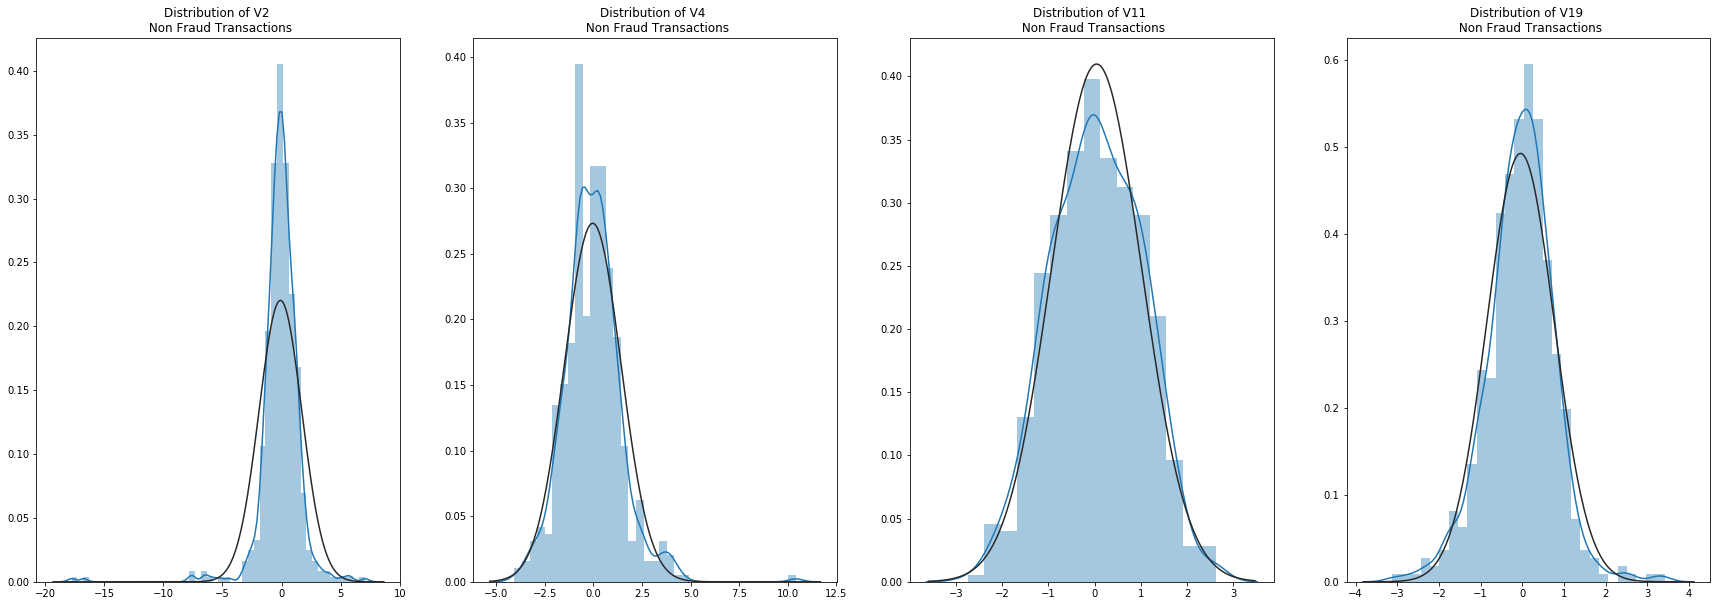

In [15]:
plot_distribution(equal_df, [2,4,11,19], 0)

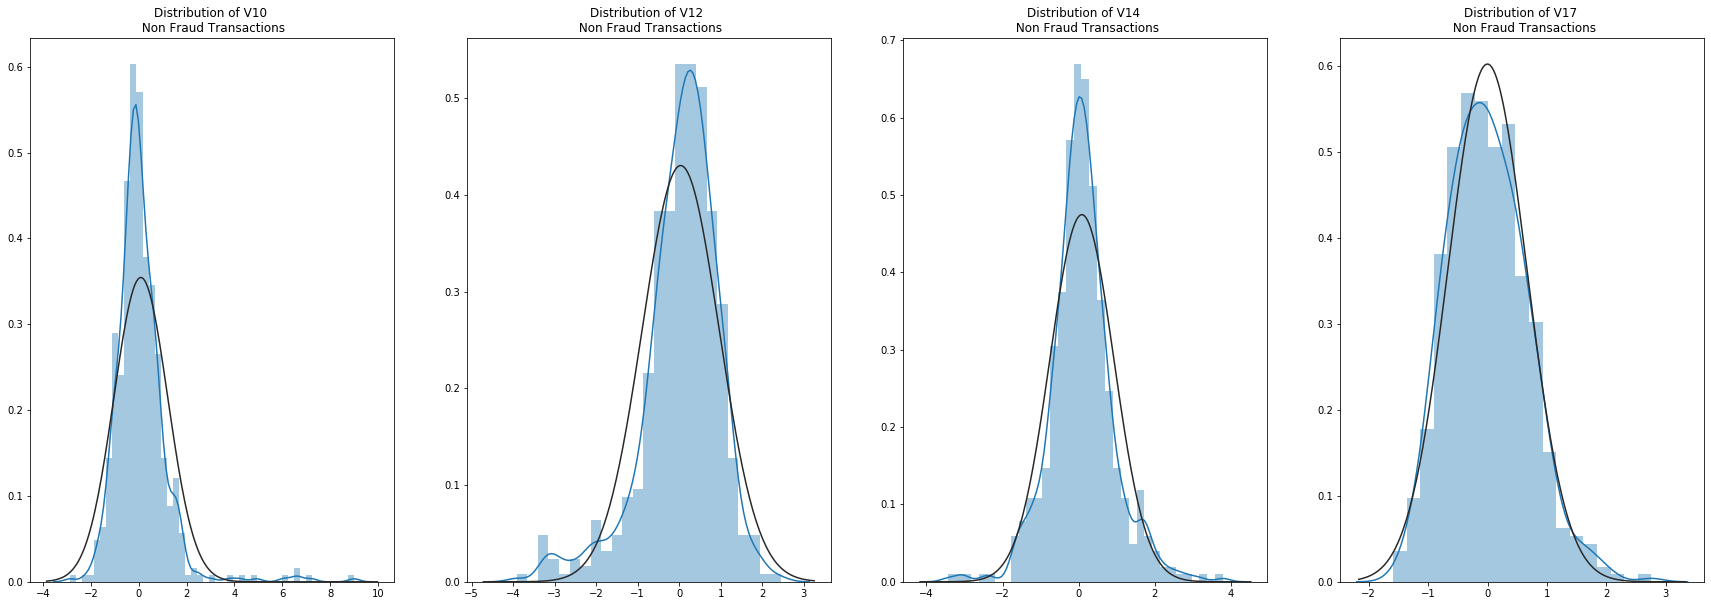

In [16]:
plot_distribution(equal_df, [10,12,14,17], 0)

Because the majority of the above columns are NOT normally distributed, you wouldn't want to remove outliers using the sigma approach. Instead, you'd want to use the interquantile range. This better suits the data. 

In [1]:
def outlier_remover(dataframe, column, threshold):
    '''
    This function will take in a dataframe and the name of a column. It will 
    then remove outliers based upon the threshold.
    ---------------------------------------------------------------------------
    dataframe: Pandas Dataframe
        This will be the dataframe of all the features.
        
    column: String
        This should be the name of a column in the above dataframe.
        
    threshold: float
        This will be multiplied by the Inner Quantile Range. The smaller the 
        value, the more data removed and vice versa. 
    ---------------------------------------------------------------------------
    Returns a Pandas Dataframe. It will be a subset of the original data frame.
    '''
    
    holder = dataframe.loc[ dataframe['Class'] == 1 ] # Only looking at the "Bad" cases
    q25, q75 = percentile(holder[column], 25), percentile(holder[column], 75) # This gives us the different percentiles for a specific column
    iqr = q75 - q25 # The interquartile range is found; it is the difference of the 75th and 25th percentiles
    cut_off = iqr * threshold # We define the threshold as the interquartile range multiplied by some specified factor
    lower, upper = q25 - cut_off, q75 + cut_off # We modify the upper and lower bounds using the cut off define above.
    
    top_out = list(holder[column] < upper) # This will return a boolean array, where it is True if smaller than the "upper" value. False otherwise.
    bottom_out = list(holder[column] > lower) # This will return a boolean array, where it is True if it is larger than the "lower" value. False otherwise.
    index = list(holder.index) # This is just the list of indices that the "holder" dataframe takes from the original dataframe.
    outliers = [x and y for x,y in zip(top_out, bottom_out)] # We only want a True response if a value is between upper and lower. So it would have to satisfy True for both of the above arrays. This list comprehension checks both at the same time by using the zip command.
    rows = [label for label,boolean in zip(index, outliers) if boolean is False] # We create a list of rows where the above list is False.
    
    return dataframe[column].drop(np.unique(rows)), np.unique(rows) # We drop the rows from the dataframe that are out of our cut off values. We return this new column and also which rows are dropped. 

With the above code, we can specify any column we want to remove outliers. As a reminder, we decided to remove the columns V2, V10, and V11. I could have written these manually, but I thought it would be more fun to write a list comprehension that does it all for me. Once I have the list of columns I want to remove, I begin finding which rows need to be removed for each column. I put all these row indices into one list and then drop them all in one step. It turns out, less than 100 rows will need to be removed.

In [18]:
columns = ['V'+str(num) for num in [2,10,11]]
rows = []
for col in columns:
    new_row = outlier_remover(equal_df, col, 1.5)[1]
    for value in new_row:
        rows.append(value)
        
new_df = equal_df.drop(rows)
X_new = new_df.drop(labels = 'Class', axis = 1)
y_new = new_df['Class']
print('There are now %i rows in our dataframe. Originally there were %i rows.' %(len(new_df), len(equal_df)) )

There are now 922 rows in our dataframe. Originally there were 984 rows.


In [19]:
percentage_finder(y_new)

Non-Fraud occurences: 492, Fraud occurences: 430
Percentage that are Non-Fraud: 53.36
Percentage that are Fraud: 46.64


As before, I created new variables to hold the transformed data. The dataframe 'new_df' is a subset of 'equal_df' where some outliers are removed from the specified columns. The corresponding X and y variables are defined similarly.

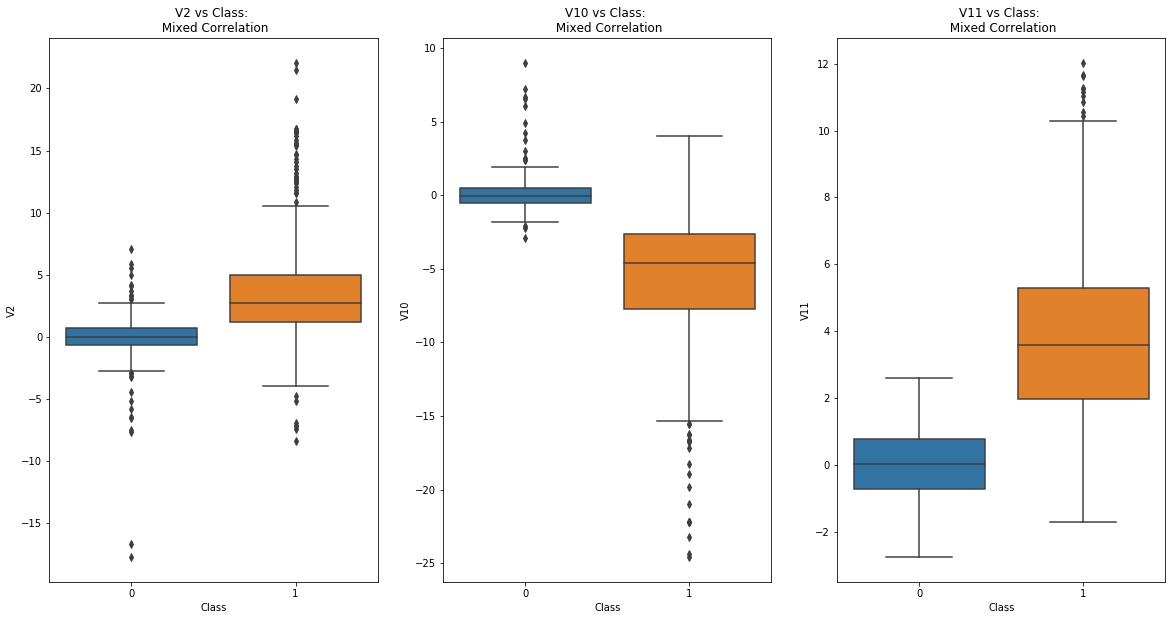

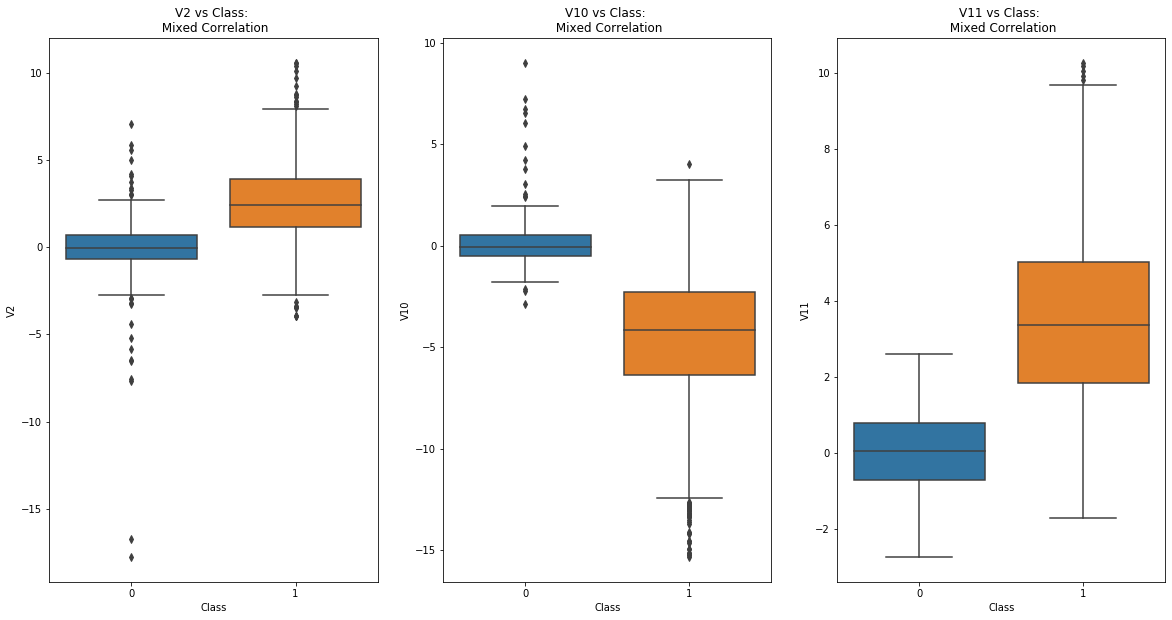

In [20]:
plot_boxplot(equal_df, [2,10,11], 'Mixed')
plot_boxplot(new_df, [2,10,11], 'Mixed')

## Dimensionality Reduction
Now that we have a more stable dataset, we can utilize different dimensionality reduction techniques. I will reduce the dimension to 3 so that they can be visualized. Then I will check to see if the reduced data can be used to cluster the different classes together.

In [21]:
def reducer(X, method):
    '''
    This function will take in the features from a dataframe and reduce it to 
    2 dimensions. It will return the new dataframe and also print out the amount
    of time required to accomplish this task.
    ---------------------------------------------------------------------------
    X: Pandas Dataframe
        This should contain all the features so that they can be reduced.
        
    method: Scikit Learn algorithm
        This can be any reduction algorithm in Scikit learn. However it only does
        simple inputs.
    ---------------------------------------------------------------------------
    Returns: Pandas Dataframe
        This new dataframe is reduced to two dimensions for plotting purposes.
        It will also print out the amount of time to accomplish this task.
    '''
    X_holder = method(n_components = 3, random_state = 42).fit_transform(X)
    return X_holder


def plot_scatter(X,y,method):
    '''
    This function will produce a scatter plot of the features.
    ---------------------------------------------------------------------------
    X: Pandas Dataframe
        This should be the features you want to create a scatter plot for.
        
    y: Pandas Series
        This should be the labels for X
        
    method: Scikit Learn Method
        This is the type of dimensionality reduction technique you want to use
    ---------------------------------------------------------------------------
    Plots the scatter plot after dimensionality reduction.
    '''
    x = reducer(X,method)
    fig, axis = plt.subplots(1, 1, figsize=(10,10))

    blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
    red_patch = mpatches.Patch(color='#AF0000', label='Fraud')
    axis.scatter(x[:,1], x[:,2], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
    axis.scatter(x[:,1], x[:,2], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
    axis.set_title(method.__name__ + ' Dimensionality Reduction', fontsize=14)
    axis.grid(True)
    axis.legend(handles=[blue_patch, red_patch])
    plt.show()

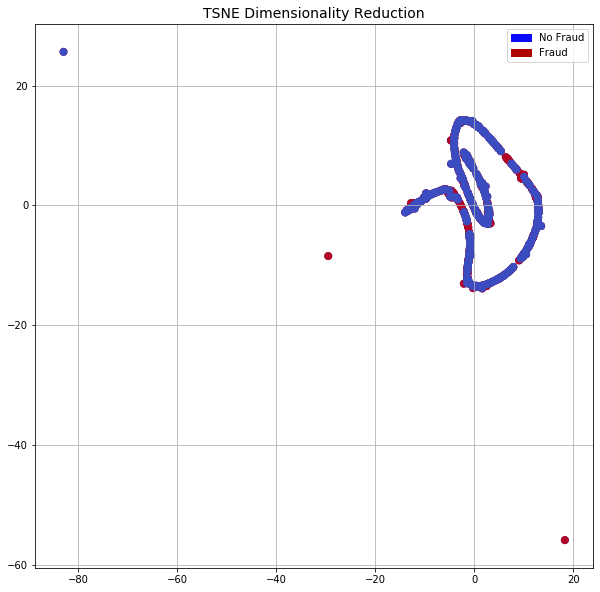

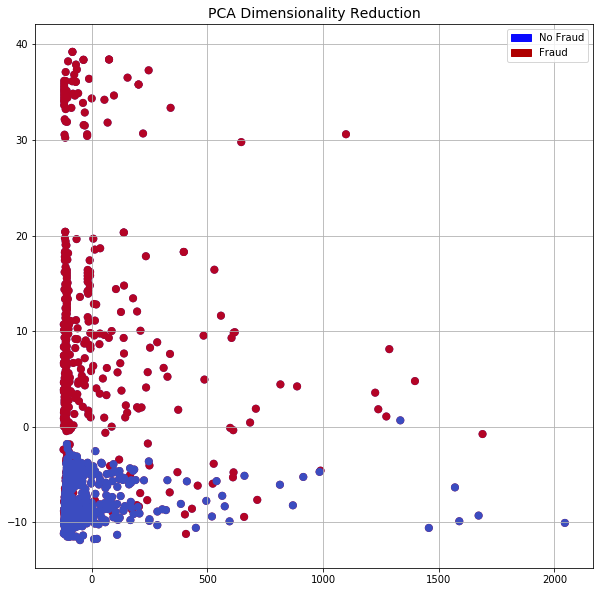

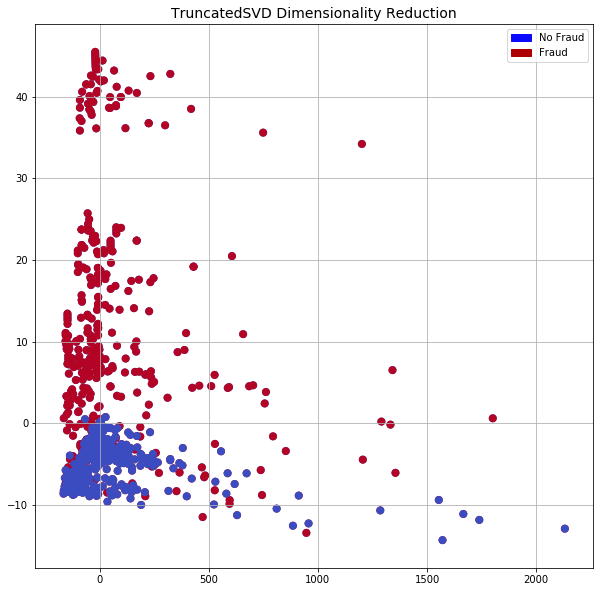

In [22]:
methods = [TSNE, PCA, TruncatedSVD]
for method in methods:
    plot_scatter(X_new, y_new, method)

It isn't a perfect separation, but it does look like this can be useful to separate the classes. PCA seems to give the best results, let us see how they perform. 

In [23]:
'''
I will do a standard 80-20 split with the data. Because PCA gave the best separation (at least visually), I plan on using
that technique to reduce the dimension of the origianl dataframe.
'''
X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(reducer(X_new,PCA), y_new,
                                            test_size=0.2, random_state=42)

'''
Based on visual inspection, I believe that the data could be linearly separated. Thus I chose to use a simple model, linear
regression. To find the best model, I need to look at a combination of many different parameters. I will choose two 
different penalty metrics and 7 different "C" values. This constant is just a penalty term that will either make the model
more strict or less strict on its classification. In total, this will look at 14 different models and find the best one. 
'''
lr_param = {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
lr_fit = GridSearchCV(LogisticRegression(), lr_param, scoring = 'f1')
lr_models = lr_fit.fit(X_new_train,y_new_train)
best_lr = lr_models.best_estimator_

score = cross_val_score(best_lr,X_new_train,y_new_train, cv = 4)
ytrain = best_lr.predict(X_new_train)
print('Logistic Regression results on Training Set:')
print('-'*100)
print('Accuracy \t Precision \t Recall')
print('%.2f \t\t %.2f \t\t %.2f' % (accuracy_score(y_new_train, ytrain)*100, precision_score(y_new_train, ytrain)*100,
                                   recall_score(y_new_train, ytrain)*100) )
print('\nThe mean score of cross validation was %.2f (+/- %.2f) \n' %(score.mean()*100, score.std()*100) )

print('Logistic Regression results on Testing Set:')
print('-'*100)
print('Accuracy \t Precision \t Recall')
y_pred = best_lr.predict(X_new_test)
print('%.2f \t\t %.2f \t\t %.2f' % (accuracy_score(y_new_test, y_pred)*100, precision_score(y_new_test, y_pred)*100,
                                   recall_score(y_new_test, y_pred)*100) )

Logistic Regression results on Training Set:
----------------------------------------------------------------------------------------------------
Accuracy 	 Precision 	 Recall
91.18 		 97.89 		 82.54

The mean score of cross validation was 90.90 (+/- 2.04) 

Logistic Regression results on Testing Set:
----------------------------------------------------------------------------------------------------
Accuracy 	 Precision 	 Recall
86.49 		 98.55 		 73.91


### Confusion Matrices
Now that we have an idea of how the model performs, I like to look at confusion matrices to visually see what the model is doing.

In [24]:
def plot_confusion_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot = True, xticklabels = labels, yticklabels = labels, fmt = 'd', cmap = 'RdYlGn')
    plt.title('Confusion Matrix for %s' %title)
    plt.xlabel('Predicted', fontsize = 15)
    plt.ylabel('Actual', fontsize = 15)
    plt.show()

Non-Fraud occurences: 399, Fraud occurences: 338
Percentage that are Non-Fraud: 54.14
Percentage that are Fraud: 45.86


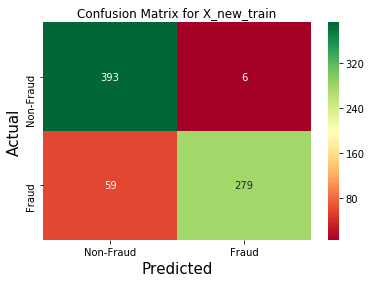

In [25]:
percentage_finder(y_new_train)
plot_confusion_matrix(y_new_train, ytrain, ['Non-Fraud', 'Fraud'], 'X_new_train')

The model does pretty well in categorizing the data. The majority, over 91.1%, of the observations are classified correctly. Also, there were only 6 false positives (where we call an event fraud when it actually wasn't). This is small, which is what we wanted. If it weren't small, many customers would be unhappy. We do see that 59 cases of fraud go unchecked, however. But this is just the training dataset. Below we will see how the test set does. 

Non-Fraud occurences: 93, Fraud occurences: 92
Percentage that are Non-Fraud: 50.27
Percentage that are Fraud: 49.73


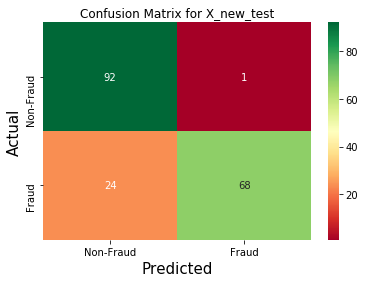

In [26]:
percentage_finder(y_new_test)
plot_confusion_matrix(y_new_test, y_pred, ['Non-Fraud', 'Fraud'], 'X_new_test' )

This testing set is quite small. Because of this, it has a very small false positive rate that can be a bit misleading. Overall it looks like the model does well, however let us see how it does on the overall dataset. 

Non-Fraud occurences: 284315, Fraud occurences: 492
Percentage that are Non-Fraud: 99.83
Percentage that are Fraud: 0.17


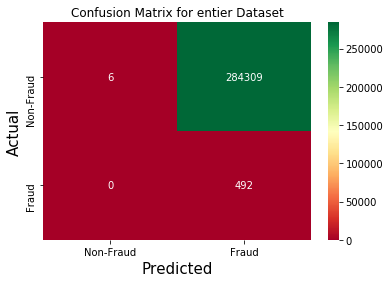

In [27]:
tot_pred = best_lr.predict(reducer(X, PCA))
percentage_finder(y)
plot_confusion_matrix(y, tot_pred, ['Non-Fraud', 'Fraud'], 'entier Dataset')

Although it isn't as accurate as a model that always predicts 'Non-Fraud', we now have a model with a high Precision rate and decent Recall rate. These can be best understood with an example.
Consider the 'Fraud' instance as a positive event and 'Non-Fraud' as a negative event. Then we would want to accurately determine when a positive event occurs as it will let us know when Fraud is taking place. High precision means that we will most likely be correct when we say a Fraud is taking place. High recall means that we catch almost all instances of Fraud occuring. There is balance that must be made here. If our model is too precise, that would suggest we are very selective when we decide if a Fraud has taken place. Thus we might have let some slip in the process. If our model has too high a recall, that means we are asserting that many Frauds are taking place. In this sense, we are capturing more Frauds, but we are also negatively impacting our customers as they might get their cards declined in this scenario. 

### KNeighbors Classifier
I wanted to see if clustering would do a better job than Logistic Regression. It did not. I plotted the data to see if I could see why, and it looks like the data is too intertwined to be clustered effectively. 

In [28]:
knn_param = {'n_neighbors': [n for n in range(3,15)], 'weights': ['uniform', 'distance'],
            'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']}
knn_fitting = GridSearchCV(KNeighborsClassifier(), knn_param, scoring = 'f1')
knn_modeling = knn_fitting.fit(X_new_train, y_new_train)
best_knn = knn_modeling.best_estimator_
pred = best_knn.predict( reducer(X,PCA) )

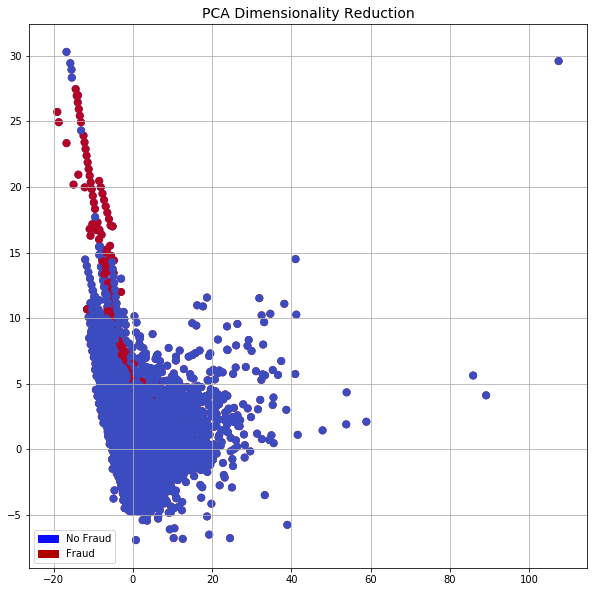

In [29]:
plot_scatter(X,y,PCA)

This was a failure. It did what I feared, it classified everything as Fraud. Those it was only correct 0.17% of the time. Its precision means that it was hardly correct, but its recall says that it didn't misclassify anything. Not useful, ignore this part.

-[Back to Top](#Fraud-Detection)

# Undersampling

## Utilizing Near Miss
Here we do not reduce the dimensions. Instead, we keep the data as is and run our models. I will start by splitting the data up in the usual way.

In [30]:
X_under_train, X_under_test, y_under_train, y_under_test = train_test_split(X_new, y_new,
                                            test_size=0.3, random_state=42, stratify = y_new)

I will use 4 classifiers for testing. Hopefully they can produce some interesting results.

In [31]:
Classifiers = [LogisticRegression, KNeighborsClassifier, DecisionTreeClassifier]

In [1]:
'''
The below code creates pipelines for different classifiers. Each classifier has different parameters and I wanted to get a good
mix of them. It's similar to what I did with the logistic regression model from above, but on a larger scale.
'''

best_models = []
for clf in Classifiers:
    if clf.__name__ == 'LogisticRegression':
        param = {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
    elif clf.__name__ == 'KNeighborsClassifier':
        param = {'n_neighbors': [n for n in range(3,15)], 'weights': ['uniform', 'distance'],
            'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']}
    elif clf.__name__ == 'DecisionTreeClassifier':
        param = {"criterion": ["gini", "entropy"], "max_depth": [n for n in range(2,5)], 
              "min_samples_leaf": [n for n in range(4,9)]}
    else:
        break
        
    fitting = GridSearchCV(clf(), param, scoring = 'f1')
    modeling = fitting.fit(X_under_train, y_under_train)
    best = modeling.best_estimator_
    best_models.append(best)

NameError: name 'Classifiers' is not defined

In [33]:
clf = [model.__name__ for model in Classifiers]
def model_scores(models, X, y, Classifier, Print = False):
    scores = []
    for model in models:
        pred = model.predict(X)
        scores.append( {'Accuracy': accuracy_score(y, pred),
                       'Precision': precision_score(y, pred),
                       'Recall': recall_score(y, pred)} )
    if Print:
        for i in range(len(scores)):
            print('\nClassifier:', Classifier[i], '\nResults:', scores[i])
    return scores

In [34]:
training_scores = model_scores(best_models, X_under_train, y_under_train, clf, Print = True)


Classifier: LogisticRegression 
Results: {'Accuracy': 0.9627906976744186, 'Precision': 0.9893992932862191, 'Recall': 0.9302325581395349}

Classifier: KNeighborsClassifier 
Results: {'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0}

Classifier: DecisionTreeClassifier 
Results: {'Accuracy': 0.9596899224806201, 'Precision': 0.9963898916967509, 'Recall': 0.9169435215946844}


In [35]:
testing_scores = model_scores(best_models, X_under_test, y_under_test, clf, Print = True)


Classifier: LogisticRegression 
Results: {'Accuracy': 0.9458483754512635, 'Precision': 0.9453125, 'Recall': 0.937984496124031}

Classifier: KNeighborsClassifier 
Results: {'Accuracy': 0.6462093862815884, 'Precision': 0.6260162601626016, 'Recall': 0.5968992248062015}

Classifier: DecisionTreeClassifier 
Results: {'Accuracy': 0.9422382671480144, 'Precision': 0.952, 'Recall': 0.9224806201550387}


Because Logistic Regression does so well, it leads me to believe that these classes can be separated by some sort of hyperplane. I wanted to see how a Support Vector Machine would work, but the dataset was too large and the model was too costly. It would time out or crash my laptop in all my attempts :(

In [36]:
total_score = model_scores(best_models, X, y, clf, Print = True)


Classifier: LogisticRegression 
Results: {'Accuracy': 0.8841320613608514, 'Precision': 0.010156108733650774, 'Recall': 0.6849593495934959}

Classifier: KNeighborsClassifier 
Results: {'Accuracy': 0.9982725143693799, 'Precision': 0.0, 'Recall': 0.0}

Classifier: DecisionTreeClassifier 
Results: {'Accuracy': 0.9481368084351859, 'Precision': 0.002439194368945571, 'Recall': 0.07113821138211382}


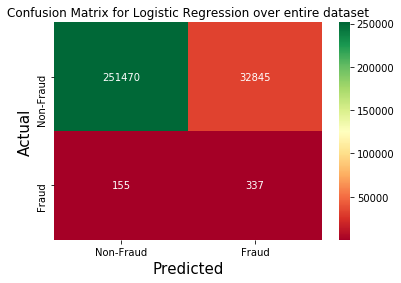

In [37]:
plot_confusion_matrix(y, best_models[0].predict(X), ['Non-Fraud', 'Fraud'], 'Logistic Regression over entire dataset')

In [38]:
percentage_finder(y)

Non-Fraud occurences: 284315, Fraud occurences: 492
Percentage that are Non-Fraud: 99.83
Percentage that are Fraud: 0.17


It does a far better job at predicting than our usage of dimensionality reduction. However, it still categorizes over 59K instances as Fraud when they actually aren't. It catches more mistakes in this scenario, but doesn't help in the long run. It might be best to balance the F1 Score rather than recall or precision individually.

-[Back to Top](#Fraud-Detection)

# Oversampling

## Utilizing SMOTE

SMOTE stands for "Syntetic Minority Over-Sampling Technique". It is actually a pretty simple process. As the name states, we want to synthetically create data for the minority class in a data set. To accomplish this, you randomly choose a data point in the minority class. You then look at its k nearest neighbors. Then you randomly choose two points from this set and take either their sum or difference. You will then multiply this vector with a value between zero and one. This resulting vector is the new point in your minority class. You continue this process until a reasonable proportion is obtained. 

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y)

The below code does what was explained above. Here I chose to have the fraud instances be 70% of the data and I only look at 6 neighbors. This is to save some time in computation as there will be over 25,000 points created. 

In [40]:
oversample = SMOTE(sampling_strategy = 0.7, random_state = 12, k_neighbors = 6)
X_res, y_res = oversample.fit_resample(X_train, y_train)
X_res = pd.DataFrame(X_res)
y_res = pd.DataFrame(y_res)

In [41]:
# better_models = []
# for clf in Classifiers:
#     if clf.__name__ == 'LogisticRegression':
#         param = {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
#     elif clf.__name__ == 'KNeighborsClassifier':
#         param = {'n_neighbors': [n for n in range(3,15)], 'weights': ['uniform', 'distance'],
#             'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']}
#     elif clf.__name__ == 'DecisionTreeClassifier':
#         param = {"criterion": ["gini", "entropy"], "max_depth": [n for n in range(2,5)], 
#               "min_samples_leaf": [n for n in range(4,9)]}
#     else:
#         break
#     fitting = GridSearchCV(clf(), param, scoring = 'f1')
#     modeling = fitting.fit(X_res, y_res)
#     best = modeling.best_estimator_
#     better_models.append(best)

# lr_param = {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
# fitting = GridSearchCV(LogisticRegression(), lr_param, scoring = 'f1')
# modeling = fitting.fit(X_res, y_res)
# best_lr = modeling.best_estimator_
lr = LogisticRegression()
lr.fit(X_res, y_res)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

I ended up only creating a logistic regression model because it took too long to do an exhaustive comparison with many different models. Usually logistic regression performs well, and it runs very quickly so it was my preferred choice. 


Classifier: Logistic Regression 
Results: {'Accuracy': 0.9590168295234887, 'Precision': 0.9795266199810403, 'Recall': 0.9196922060955827}


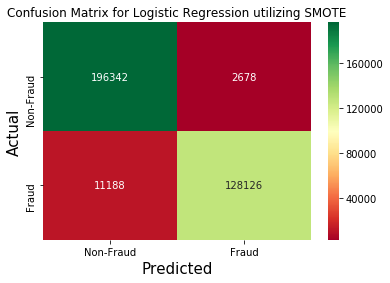

In [42]:
training_scores = model_scores([lr], X_res,y_res, ['Logistic Regression'], Print = True)
plot_confusion_matrix(y_res, lr.predict(X_res), ['Non-Fraud', 'Fraud'], 'Logistic Regression utilizing SMOTE')

The model does a fairly good job in distinguishing the two classes. There are quite a bit False Negatives, maybe more than I would like. But there are also very little False Positives. This could be difficult to balance, but I would believe a False Negative would be more harmful than a False Positive. 


Classifier: Logistic Regression 
Results: {'Accuracy': 0.9860608826937256, 'Precision': 0.09791827293754819, 'Recall': 0.8581081081081081}


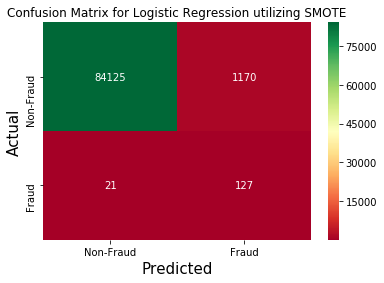

In [43]:
testing_scores = model_scores([lr], X_test,y_test, ['Logistic Regression'], Print = True)
plot_confusion_matrix(y_test, lr.predict(X_test), ['Non-Fraud', 'Fraud'], 'Logistic Regression utilizing SMOTE')


Classifier: Logistic Regression 
Results: {'Accuracy': 0.9863275832405805, 'Precision': 0.10386585933861202, 'Recall': 0.9065040650406504}


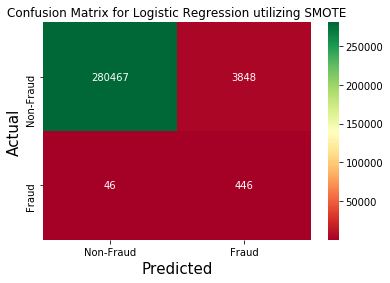

In [44]:
total_scores = model_scores([lr], X,y, ['Logistic Regression'], Print = True)
plot_confusion_matrix(y, lr.predict(X), ['Non-Fraud', 'Fraud'], 'Logistic Regression utilizing SMOTE')

In [45]:
lr_param = {'penalty': ['l1', 'l2'], 'C': [0.01, 1, 100]}
fitting = GridSearchCV(LogisticRegression(), lr_param, scoring = 'f1')
modeling = fitting.fit(X_res, y_res)
best_lr = modeling.best_estimator_


Classifier: Logistic Regression 
Results: {'Accuracy': 0.9590345634786926, 'Precision': 0.9795275590551181, 'Recall': 0.9197352742725067}


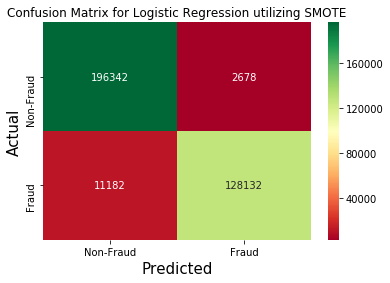

In [46]:
training_scores = model_scores([best_lr], X_res,y_res, ['Logistic Regression'], Print = True)
plot_confusion_matrix(y_res, best_lr.predict(X_res), ['Non-Fraud', 'Fraud'], 'Logistic Regression utilizing SMOTE')


Classifier: Logistic Regression 
Results: {'Accuracy': 0.9860374752759149, 'Precision': 0.09776751347190146, 'Recall': 0.8581081081081081}


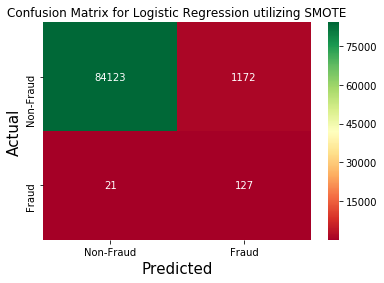

In [47]:
testing_scores = model_scores([best_lr], X_test,y_test, ['Logistic Regression'], Print = True)
plot_confusion_matrix(y_test, best_lr.predict(X_test), ['Non-Fraud', 'Fraud'], 'Logistic Regression utilizing SMOTE')


Classifier: Logistic Regression 
Results: {'Accuracy': 0.986320560941269, 'Precision': 0.10381750465549348, 'Recall': 0.9065040650406504}


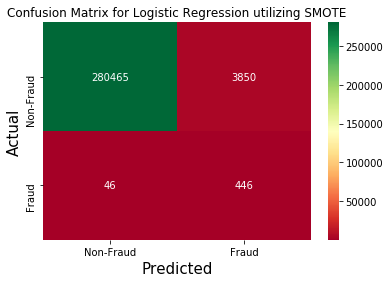

In [48]:
total_scores = model_scores([best_lr], X,y, ['Logistic Regression'], Print = True)
plot_confusion_matrix(y, best_lr.predict(X), ['Non-Fraud', 'Fraud'], 'Logistic Regression utilizing SMOTE')

This model actually does a really good job in finding fraud instances. It sacrifices a bit of accuracy to do, but it is entirely worth it. We catch 90% of fraud instances!

In [49]:
print(lr)
print(best_lr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


## Undestanding the Results
From the Confusion Matrices, we see that SMOTE actually does the best job at Recall than any other technique. I've ran the Logistic Regression model because it looked like the data could be separated by a hyperplane. 

[Back to Top](#Fraud-Detection)

# Conclusion

A few different techniques were used to detect Fraud occurences. They are as follows:
* Dimensionality Reduction: This proved to be the worse approach. It did awful at detecting fraud instances.
* Oversampling: This did a decent job, however it suffered from Information Loss. Too much data had to be removed to create models in this scenario. Because we have so much information, it is best to use as much of it as possible. 
* Undersampling: Here we create more data points for the minority class (which is fraud instances for this workbook). It might have performed better with different models, but they took quite a bit of time to train. This was to be expected, though. Because we created so many synthetic points, our dataset grew to be extremely large. 